In [ ]:


import numpy as np

# To register the hparams set
from tensor2tensor import models  # pylint: disable=unused-import
from tensor2tensor import problems
from tensor2tensor.utils import registry
from tensor2tensor.utils import trainer_lib
from scipy import ndimage

import tensor2tensor.data_generators.imagenet as imagenet

import tensorflow as tf

EOS_ID = 1


class AttentionVisualizer(object):
  """Helper object for creating Attention visualizations."""

  def __init__(
      self, hparams_set, use_bottom_up_features, model_name, data_dir, problem_name, beam_size=1):

    if use_bottom_up_features:
      inputs, bottom_up_features, objet_boxes, targets, samples, att_mats = build_model_object(
        hparams_set, model_name, data_dir, problem_name, beam_size=beam_size)
    else:
      inputs, targets, samples, att_mats = build_model(
        hparams_set, model_name, data_dir, problem_name, beam_size=beam_size)

    # Fetch the problem
    ende_problem = problems.problem(problem_name)
    encoders = ende_problem.feature_encoders(data_dir)

    self.inputs = inputs
    self.targets = targets
    self.att_mats = att_mats
    self.samples = samples
    self.encoders = encoders
    self.bottom_up_features = None
    self.object_boxes = None
    if use_bottom_up_features:
      self.bottom_up_features = bottom_up_features
      self.object_boxes = objet_boxes

  def encode(self, input_str):
    """Input str to features dict, ready for inference."""
    inputs = self.encoders['inputs'].encode(input_str) + [EOS_ID]
    batch_inputs = np.reshape(inputs, [1, -1, 1, 1])  # Make it 3D.
    return batch_inputs

  def encode_image(self, input_image):
    """Input str to features dict, ready for inference."""

    g_1 = tf.Graph()
    with g_1.as_default():
      # Operations created in this scope will be added to `g_1`.
      image = tf.placeholder(dtype=tf.float32, shape=[None, None, 3], name="image_placeholder")
      preprocessed_image, image_resized = imagenet.preprocess_for_visualize(image, 224)

      # Sessions created in this scope will run operations from `g_1`.

      with tf.Session() as sess_1:
        tf.global_variables_initializer().run()
        preprocessed_input_image, image_input_resized = sess_1.run([preprocessed_image, image_resized], feed_dict={image: input_image})

    batch_inputs = np.reshape(preprocessed_input_image, [1, 224, 224, 3])  # Make it 3D.

    '''
    batch_inputs =  np.expand_dims(input_image, axis=0)  # Make it 3D.
    '''
    return batch_inputs, image_input_resized

  def encode_bottom_up_feature(self, input_bottom_up_features):
    batch_inputs = np.reshape(np.asarray(input_bottom_up_features), [1, -1, 2048, 1])  # Make it 3D.
    return batch_inputs

  def encode_object_boxes(self, input_object_boxes):
    batch_inputs = np.reshape(np.asarray(input_object_boxes), [1, -1, 4])  # Make it 3D.
    return batch_inputs

  def decode(self, integers):
    """List of ints to str."""
    integers = list(np.squeeze(integers))
    return self.encoders['targets'].decode(integers)

  def decode_list(self, integers):
    """List of ints to list of str."""
    integers = list(np.squeeze(integers))
    return self.encoders['targets'].decode_list(integers)

  def get_vis_data_from_string(self, sess, input_string):
    """Constructs the data needed for visualizing attentions.
    Args:
      sess: A tf.Session object.
      input_string: The input setence to be translated and visulized.
    Returns:
      Tuple of (
          output_string: The translated sentence.
          input_list: Tokenized input sentence.
          output_list: Tokenized translation.
          att_mats: Tuple of attention matrices; (
              enc_atts: Encoder self attention weights.
                A list of `num_layers` numpy arrays of size
                (batch_size, num_heads, inp_len, inp_len)
              dec_atts: Decoder self attention weights.
                A list of `num_layers` numpy arrays of size
                (batch_size, num_heads, out_len, out_len)
              encdec_atts: Encoder-Decoder attention weights.
                A list of `num_layers` numpy arrays of size
                (batch_size, num_heads, out_len, inp_len)
          )
    """
    encoded_inputs = self.encode(input_string)

    # Run inference graph to get the translation.
    out = sess.run(self.samples, {
        self.inputs: encoded_inputs,
    })

    # Run the decoded translation through the training graph to get the
    # attention tensors.
    att_mats = sess.run(self.att_mats, {
        self.inputs: encoded_inputs,
        self.targets: np.reshape(out, [1, -1, 1, 1]),
    })

    output_string = self.decode(out)
    input_list = self.decode_list(encoded_inputs)
    output_list = self.decode_list(out)

    return output_string, input_list, output_list, att_mats

  def get_vis_data_from_image(self, sess, image_id, image_path, bottom_up_features, object_boxes, use_bottom_up_features):
    """Constructs the data needed for visualizing attentions.
    Args:
      sess: A tf.Session object.
      input_string: The input setence to be translated and visulized.
    Returns:
      Tuple of (
          output_string: The translated sentence.
          input_list: Tokenized input sentence.
          output_list: Tokenized translation.
          att_mats: Tuple of attention matrices; (
              enc_atts: Encoder self attention weights.
                A list of `num_layers` numpy arrays of size
                (batch_size, num_heads, inp_len, inp_len)
              dec_atts: Decoder self attention weights.
                A list of `num_layers` numpy arrays of size
                (batch_size, num_heads, out_len, out_len)
              encdec_atts: Encoder-Decoder attention weights.
                A list of `num_layers` numpy arrays of size
                (batch_size, num_heads, out_len, inp_len)
          )
    """

    image = ndimage.imread(image_path, mode='RGB')
    encoded_inputs, resized_image = self.encode_image(image)

    if use_bottom_up_features:
      encoded_bottom_up_features = self.encode_bottom_up_feature(bottom_up_features)
      encoded_object_boxes = self.encode_object_boxes(object_boxes)

      # Run inference graph to get the translation.
      out = sess.run(self.samples, {
        self.inputs: encoded_inputs,
        self.bottom_up_features: encoded_bottom_up_features,
        self.object_boxes: encoded_object_boxes
      })

      # Run the decoded translation through the training graph to get the
      # attention tensors.
      att_mats = sess.run(self.att_mats, {
        self.inputs: encoded_inputs,
        self.bottom_up_features: encoded_bottom_up_features,
        self.object_boxes: encoded_object_boxes,
        self.targets: np.reshape(out, [1, -1, 1, 1]),
      })

    else:
      # Run inference graph to get the translation.
      out = sess.run(self.samples, {
          self.inputs: encoded_inputs,
      })

      # Run the decoded translation through the training graph to get the
      # attention tensors.
      att_mats = sess.run(self.att_mats, {
          self.inputs: encoded_inputs,
          self.targets: np.reshape(out, [1, -1, 1, 1]),
      })

    output_string = self.decode(out)
    print(output_string)
    #input_list = list(range(0, 196))
    input_list = resized_image
    output_list = output_string
    #input_list = self.decode_list(encoded_inputs)
    output_list = self.decode_list(out)

    return output_string,  input_list, output_list, att_mats

def build_model(hparams_set, model_name, data_dir, problem_name, beam_size=1):
  """Build the graph required to featch the attention weights.
  Args:
    hparams_set: HParams set to build the model with.
    model_name: Name of model.
    data_dir: Path to directory contatining training data.
    problem_name: Name of problem.
    beam_size: (Optional) Number of beams to use when decoding a traslation.
        If set to 1 (default) then greedy decoding is used.
  Returns:
    Tuple of (
        inputs: Input placeholder to feed in ids to be translated.
        targets: Targets placeholder to feed to translation when fetching
            attention weights.
        samples: Tensor representing the ids of the translation.
        att_mats: Tensors representing the attention weights.
    )
  """
  ''''
  hparams = trainer_lib.create_hparams(
      hparams_set, data_dir=data_dir, problem_name=problem_name, hparams_overrides_str='num_encoder_layers=6')
  '''
  hparams = trainer_lib.create_hparams(
      hparams_set, data_dir=data_dir, problem_name=problem_name, hparams_overrides_str='')
  translate_model = registry.model(model_name)(
      hparams, tf.estimator.ModeKeys.EVAL)

  #inputs = tf.placeholder(tf.int32, shape=(1, None, 1, 1), name='inputs')
  inputs = tf.placeholder(tf.int32, shape=(1, None, None, 3), name='inputs')
  targets = tf.placeholder(tf.int32, shape=(1, None, 1, 1), name='targets')
  translate_model({
      'inputs': inputs,
      'targets': targets,
  })

  # Must be called after building the training graph, so that the dict will
  # have been filled with the attention tensors. BUT before creating the
  # interence graph otherwise the dict will be filled with tensors from
  # inside a tf.while_loop from decoding and are marked unfetchable.
  att_mats = get_att_mats(translate_model)

  with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    samples = translate_model.infer({
        'inputs': inputs,
    }, beam_size=beam_size)['outputs']

  return inputs, targets, samples, att_mats

def build_model_object(hparams_set, model_name, data_dir, problem_name, beam_size=1):
  """Build the graph required to featch the attention weights.
  Args:
    hparams_set: HParams set to build the model with.
    model_name: Name of model.
    data_dir: Path to directory contatining training data.
    problem_name: Name of problem.
    beam_size: (Optional) Number of beams to use when decoding a traslation.
        If set to 1 (default) then greedy decoding is used.
  Returns:
    Tuple of (
        inputs: Input placeholder to feed in ids to be translated.
        targets: Targets placeholder to feed to translation when fetching
            attention weights.
        samples: Tensor representing the ids of the translation.
        att_mats: Tensors representing the attention weights.
    )
  """
  ''''
  hparams = trainer_lib.create_hparams(
      hparams_set, data_dir=data_dir, problem_name=problem_name, hparams_overrides_str='num_encoder_layers=6')
  '''
  hparams = trainer_lib.create_hparams(
      hparams_set, data_dir=data_dir, problem_name=problem_name, hparams_overrides_str='')
  translate_model = registry.model(model_name)(
      hparams, tf.estimator.ModeKeys.EVAL)

  #inputs = tf.placeholder(tf.int32, shape=(1, None, 1, 1), name='inputs')
  inputs = tf.placeholder(tf.int32, shape=(1, None, None, 3), name='inputs')
  bottom_up_features = tf.placeholder(tf.float32, shape=(1, None, 2048, 1), name='bottom_up_features')
  object_boxes = tf.placeholder(tf.float32, shape=(1, None, 4), name='object_boxes')
  targets = tf.placeholder(tf.int32, shape=(1, None, 1, 1), name='targets')
  translate_model({
      'inputs': inputs,
      'bottom_up_features': bottom_up_features,
      'object_boxes': object_boxes,
      'targets': targets,
  })

  # Must be called after building the training graph, so that the dict will
  # have been filled with the attention tensors. BUT before creating the
  # interence graph otherwise the dict will be filled with tensors from
  # inside a tf.while_loop from decoding and are marked unfetchable.
  att_mats = get_att_mats(translate_model)

  with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    samples = translate_model.infer({
        'inputs': inputs,
        'bottom_up_features': bottom_up_features,
        'object_boxes': object_boxes,
    }, beam_size=beam_size)['outputs']

  return inputs, bottom_up_features, object_boxes, targets, samples, att_mats

def get_att_mats(translate_model):
  """Get's the tensors representing the attentions from a build model.
  The attentions are stored in a dict on the Transformer object while building
  the graph.
  Args:
    translate_model: Transformer object to fetch the attention weights from.
  Returns:
  Tuple of attention matrices; (
      enc_atts: Encoder self attention weights.
        A list of `num_layers` numpy arrays of size
        (batch_size, num_heads, inp_len, inp_len)
      dec_atts: Decoder self attetnion weights.
        A list of `num_layers` numpy arrays of size
        (batch_size, num_heads, out_len, out_len)
      encdec_atts: Encoder-Decoder attention weights.
        A list of `num_layers` numpy arrays of size
        (batch_size, num_heads, out_len, inp_len)
  )
  """
  enc_atts = []
  dec_atts = []
  encdec_atts = []

  prefix = 'transformer/body/'
  postfix = '/multihead_attention/dot_product_attention'

  for i in range(translate_model.hparams.num_hidden_layers):
    '''
    if i < translate_model.hparams.num_encoder_layers:
      enc_att = translate_model.attention_weights[
          '%sencoder/layer_%i/self_attention%s' % (prefix, i, postfix)]
      enc_atts.append(enc_att)
    '''
    enc_att = translate_model.attention_weights[
      '%sencoder/layer_%i/self_attention%s' % (prefix, i, postfix)]
    enc_atts.append(enc_att)
    dec_att = translate_model.attention_weights[
      '%sdecoder/layer_%i/self_attention%s' % (prefix, i, postfix)]
    encdec_att = translate_model.attention_weights[
        '%sdecoder/layer_%i/encdec_attention%s' % (prefix, i, postfix)]

    dec_atts.append(dec_att)
    encdec_atts.append(encdec_att)

  return enc_atts, dec_atts, encdec_atts

In [5]:
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [19]:
import sys

 
csv.field_size_limit(sys.maxsize)
csv.field_size_limit(500 * 1024 * 1024)

9223372036854775807

In [6]:
image_file_name = 'COCO_val2014_000000076619'
image_file_parts = image_file_name.split('_')
image_id = int(image_file_parts[2])
image_path = os.path.expanduser('/home/sdb1/why/COCO/val2014/'+image_file_name+'.jpg')



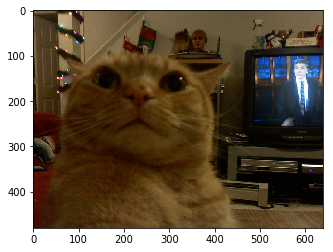

In [9]:
image = Image.open(image_path)
plt.imshow(image)
plt.show()



In [21]:
bottom_up_feature_filepath = os.path.expanduser('/home/sdb1/why/COCO/trainval_36/trainval_resnet101_faster_rcnn_genome_36.tsv')


In [22]:
FIELDNAMES = ['image_id', 'image_w','image_h','num_boxes', 'boxes', 'features']

In [24]:
import base64

In [27]:
with open(bottom_up_feature_filepath, "r+b") as tsv_in_file:
    reader = csv.DictReader(tsv_in_file, delimiter='\t', fieldnames=FIELDNAMES)
    for item in reader:
        item['image_id'] = int(item['image_id'])
        item['image_h'] = int(item['image_h'])
        item['image_w'] = int(item['image_w'])
        item['num_boxes'] = int(item['num_boxes'])
        for field in ['boxes', 'features']:
            item[field] = np.frombuffer(base64.decodestring(item[field]),
                                        dtype=np.float32).tolist()
        if image_id == item['image_id']:
            print('Found Matching object features')
            break



/home/why/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: decodestring() is a deprecated alias since Python 3.1, use decodebytes()
  if __name__ == '__main__':


TypeError: expected bytes-like object, not str

In [ ]:
output_string, inp_text, out_text, att_mats = visualizer.get_vis_data_from_image(sess, image_id, image_path, item['features'], item['boxes'], use_bottom_up_features)
save_objects([output_string, inp_text, out_text, att_mats])


output_string, inp_text, out_text, att_mats = restore_objects()
print(np.shape(att_mats[0]))
print(np.shape(att_mats[1]))
print(np.shape(att_mats[2]))
print(output_string)


if use_bottom_up_features:
    img = ndimage.imread(image_path, mode='RGB')
    for l in range(4,6):
        for a in range(8):
            # Plot original image
            # img = ndimage.imread(image_path)
            plt.subplot(4, 4, 1)
            plt.imshow(img)
            plt.axis('off')

            # Plot images with attention weights
            words = out_text
            for t in range(len(words)):
                plt.subplot(4, 4, t + 2)
                words[t] = words[t].replace('_', '')
                plt.text(0, 1, '%s' % words[t], color='black', backgroundcolor='white', fontsize=8)
                plt.imshow(img)
                input_output_attn = att_mats[2]
                alp_curr = np.zeros([item['image_w'], item['image_h']])
                num_boxes = item['num_boxes']
                boxes = np.asarray(item['boxes']).reshape(-1, 4)
                for box_index in range(num_boxes):
                    for x in range(int(boxes[box_index][0]), int(boxes[box_index][2])):
                        for y in range(int(boxes[box_index][1]), int(boxes[box_index][3])):
                            alp_curr[x][y] += input_output_attn[l][0][a][t][box_index]
                alp_img = alp_curr

                #alp_img = skimage.transform.pyramid_expand(alp_curr, upscale=16, sigma=20)
                plt.imshow(np.transpose(alp_img), alpha=0.5)
                plt.axis('off')
            # plt.show()
            attn_file = 'data/visualize' + str(image_file_name) \
                        + '/input_output_' + 'layer_' + str(l) + 'head' + str(a)

            directory = os.path.dirname(attn_file)
            try:
                os.stat(directory)
            except:
                os.mkdir(directory)
            plt.savefig(attn_file, format='png', dpi=1000)
    exit(0)

img = inp_text.astype(int)
for l in range(6):
    for a in range(8):
        # Plot original image
        #img = ndimage.imread(image_path)
        plt.subplot(4, 4, 1)
        plt.imshow(img)
        plt.axis('off')

        # Plot images with attention weights
        words = out_text
        for t in range(len(words)):
            plt.subplot(4, 4, t+2)
            words[t] =words[t].replace('_', '')
            plt.text(0, 1, '%s' % words[t], color='black', backgroundcolor='white', fontsize=8)
            plt.imshow(img)
            input_output_attn = att_mats[2]
            alp_curr = input_output_attn[l][0][a][t].reshape(14, 14)
            alp_img = alp_curr
            alp_img = skimage.transform.pyramid_expand(alp_curr, upscale=16, sigma=20)
            plt.imshow(alp_img, alpha=0.85)
            plt.axis('off')
        #plt.show()
        attn_file = 'data/visualize/'+ str(image_file_name) \
                    + '/input_output_' + 'layer_' + str(l) + 'head' + str(a)

        directory = os.path.dirname(attn_file)
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        plt.savefig(attn_file, format='png', dpi=1000)